Program przy pierwszym uruchomieni stworzy na pulpicie folder nazwany Notes w którym będą zapisywane rezultaty.
Do poprawnego działania tego notatnika potrzebne jest zainstalowanie programu musescore, który konwertuje xml midi na grafikę z nutami. Można go pobrać tutaj:https://musescore.org/en


Instalacja potrzebnych bibliotek.

In [1]:
! pip3 install matplotlib
! pip3 install scipy
! pip3 install music21

You are using pip version 9.0.1, however version 20.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 20.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 20.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import copy
import platform
import random
import sys,os,os.path
import socket
from music21 import *
from music21 import interval
from music21 import scale
from music21.note import Note, Rest
from music21 import interval
from music21 import scale
from music21.note import Note
from NotesRelationshipConfig import NotesRelationshipConfig

Dodatkowa konfiguracja dla Bindera.

In [3]:
if "jupyter" in socket.gethostname():
    sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
    os.environ['QT_QPA_PLATFORM']='offscreen'

Klasa reprezentująca pojedyńczą nutę w populacji.

In [4]:
class MusicNote(object):
    location = 0
    fitness_score = 0.0
    melody_direction_fitness = 0
    is_first_note_of_melody = False
    is_last_note_of_melody = False
    note_interval = None

    def __init__(self, music_note: Note, fitness_score: 0.0, note_interval, location, is_last=False):
        self.note_interval = note_interval
        self.music_note = music_note
        self.fitness_score = fitness_score
        self.location = location
        if location == 0:
            self.is_first_note_of_melody = True
        self.is_last_note_of_melody = is_last

    def __repr__(self):
        return repr(self.fitness_score)


Klasa reprezentująca cała populacje nut.

In [5]:
class MusicPeace(object):
    all_notes = []
    temp_notes = []
    bars_number = 0
    note_ids = []

    def __init__(self, bars_number):
        self.bars_number = bars_number
        self.get_all_notes(0.0)

    def get_all_notes(self, note_fitness_score):
        self.get_temp_notes()
        self.create_notes(note_fitness_score)

    def get_temp_notes(self):
        count = 0
        bars_count = 0
        while bars_count < self.bars_number * 4:
            tone = self.generate_scale_tone(self.temp_notes, count)
            self.temp_notes.append(tone)
            bars_count = self.calculate_if_bars_are_done()
            count = count + 1

    def calculate_if_bars_are_done(self):
        count = 0
        for note in self.temp_notes:
            count = count + note.duration.quarterLength
        return count

    @staticmethod
    def generate_scale_tone(notes: [], count):
        items = ['C', 'D', 'E', 'F', 'G', 'A', 'B', 'C#', 'D#', 'F#', 'G#', 'A#']

        rand_item = items[random.randrange(len(items))]

        scales = scale.MajorScale(rand_item)

        all_pitches = list(set([pitch for pitch in scales.getPitches()]))
        all_note_names = [i.name for i in all_pitches]

        note_name = random.choice(all_note_names)

        final_note = Note(note_name)

        duration_list = [1, 1 / 2]

        if not notes:
            final_note.duration.quarterLength = random.choice(duration_list)
            return final_note

        try:
            if notes[count - 1].duration.quarterLength == 1 / 2 and notes[count - 2].duration.quarterLength != 1 / 2:
                final_note.duration.quarterLength = 1 / 2
                return final_note
        except:
            if count == 0:
                final_note.duration.quarterLength = 1 / 2
                return final_note
            else:
                pass
        else:
            final_note.duration.quarterLength = random.choice(duration_list)
            return final_note

    def create_notes(self, note_fitness_score):
        for index in range(0, len(self.temp_notes)):
            note = self.temp_notes[index]

            if index + 1 >= len(self.temp_notes):
                note_interval = interval.Interval(note, second_note)
                self.all_notes.append(MusicNote(note, note_fitness_score, note_interval, index, is_last=True))
                continue

            second_note = self.temp_notes[index + 1]
            note_interval = interval.Interval(note, second_note)

            if index == 0:
                self.all_notes.append(MusicNote(note, note_fitness_score, note_interval, index))
                continue

            self.all_notes.append(MusicNote(note, note_fitness_score, note_interval, index))
            

Konfiguracja funkcji oceniającej zależność miedzy nutami.

In [6]:
class NotesRelationshipConfig(object):
    evaluate_one_step = True
    evaluate_two_steps = True
    evaluate_three_steps = True
    evaluate_same_distance = True

    def __init__(self, evaluate_one_step, evaluate_two_steps, evaluate_three_steps, evaluate_same_distance):
        self.evaluate_one_step = evaluate_one_step
        self.evaluate_two_steps = evaluate_two_steps
        self.evaluate_three_steps = evaluate_three_steps
        self.evaluate_same_distance = evaluate_same_distance


Funkcji oceniającej zależność miedzy nutami

In [7]:
def notes_relationship(note_one, note_two, config: NotesRelationshipConfig):
    count = 0
    fitness = 0
    if config.evaluate_one_step:
        one_step_relationship = one_step(note_one.music_note, note_two.music_note)
        count = count + 1
        fitness = fitness + one_step_relationship
    if config.evaluate_two_steps:
        two_step_relationship = two_steps(note_one.music_note, note_two.music_note)
        count = count + 1
        fitness = fitness + two_step_relationship
    if config.evaluate_three_steps:
        three_steps_relationship = three_steps(note_one.music_note, note_two.music_note)
        count = count + 1
        fitness = fitness + three_steps_relationship
    if config.evaluate_same_distance:
        same_note_relationship = same_distance(note_one.music_note, note_two.music_note)
        count = count + 1
        fitness = fitness + same_note_relationship

    if count > 0:
        return fitness / count
    else:
        return -1

def one_step(note_one, note_two):
    if interval.notesToGeneric(note_one, note_two) == 'M2' or 'm2':
        return 0.7
    else:
        return 0


def two_steps(note_one, note_two):
    if interval.notesToGeneric(note_one, note_two) == 'M3' or 'm3':
        return 1
    else:
        return 0


def three_steps(note_one, note_two):
    if interval.notesToGeneric(note_one, note_two) == 'P4' or 'A4':
        return 0.8
    else:
        return 0


def same_distance(note_one, note_two):
    if interval.notesToGeneric(note_one, note_two) == 'P1':
        return 0.2
    else:
        return 1

Klasa odpowiedzialna za konfiguracje algorytmu.

In [8]:
class AlgorithmConfig(object):
    notes_relationship_config = NotesRelationshipConfig(True, True, True, True)
    evaluate_degree = True
    evaluate_drastic_duration_change = True
    evaluate_note_melody_direction = True
    evaluate_first_or_last_note = True

    def __init__(self, evaluate_degree,
                 evaluate_drastic_duration_change,
                 evaluate_note_melody_direction,
                 evaluate_first_or_last_note,
                 notes_relationship_config: NotesRelationshipConfig):
        self.notes_relationship_config = notes_relationship_config
        self.evaluate_degree = evaluate_degree
        self.evaluate_drastic_duration_change = evaluate_drastic_duration_change
        self.evaluate_note_melody_direction = evaluate_note_melody_direction
        self.evaluate_first_or_last_note = evaluate_first_or_last_note


Funkcja oceniająca nagłą zmianę odległości miedzy nutami.

In [9]:
def drastic_duration_change_fitness_function(note1, note2):
    proportion = note1.music_note.duration.quarterLength / note2.music_note.duration.quarterLength

    if proportion > 4:
        return 0.2
    else:
        return 1


Funkcja oceniająca kąt między nutami.

In [10]:
def degree_fitness(note1: MusicNote, note2: MusicNote):
    chosen_scale = scale.MajorScale('G')
    degree1 = chosen_scale.getScaleDegreeFromPitch(note1.music_note.pitch)
    degree2 = chosen_scale.getScaleDegreeFromPitch(note2.music_note.pitch)

    if degree1 is None:
        return 0.2
    if degree2 is None:
        return 0.2

    if degree1 > degree2:
        difference = degree1 - degree2
    else:
        difference = degree2 - degree1

    if difference > 4:
        return 0.2
    else:
        return 1


Funkcje oceniające kierunek melodii.

In [11]:
def melody_direction_fitness(population):
    for index in range(0, len(population) - 2, 1):
        first_note = population[index]
        second_note = population[index + 1]
        third_note = population[index + 2]

        direction_fitness = assign_melody_direction_fitness(first_note, second_note, third_note)

        first_note.melody_direction_fitness = direction_fitness
        
def assign_melody_direction_fitness(note1: MusicNote, note2: MusicNote, note3: MusicNote):
    if note3 is None:
        return
    if note2 is None:
        return
    return fitness_melody_direction_two_notes(note1, note2)

def fitness_melody_direction_two_notes(note1: MusicNote,
                                       note2: MusicNote
                                       ):
    if note1.note_interval.direction == 1 and note2.note_interval.direction == 1:
        return 1

    if note1.note_interval.direction == -1 and \
            note2.note_interval.direction == -1:
        return 1

    if note1.note_interval.direction == 0 and \
            note2.note_interval.direction == 0:
        return 0.7
    else:
        return 0.4


Funkcje oceniające przystosowanie pierwszej lub ostatniej nuty.

In [12]:
def first_or_last_note_fitness(first_note: MusicNote, song_scale):
    if first_note.music_note.pitch.name == get_root_pitch(song_scale):
        return 1
    else:
        return 0
    
def get_root_pitch(song_scale):
    pitches = get_scale_pitches(song_scale)
    all_note_names = [i.name for i in pitches]
    return all_note_names[0]


def get_scale_pitches(scale_local):
    scale_pitches = []
    for p in scale_local.pitches:
        scale_pitches.append(p)
    return scale_pitches

Funkcja przystosowania.

In [13]:
def evaluate_fitness(population: [MusicNote], config: AlgorithmConfig):
    if config.evaluate_note_melody_direction:
        melody_direction_fitness(population)

    scales = scale.MajorScale('G')

    for index in range(0, len(population), 1):
        indexed_note = population[index]

        if population[index].is_last_note_of_melody:
            if config.evaluate_first_or_last_note:
                last_note_fitness = first_or_last_note_fitness(indexed_note, scales)
                indexed_note.fitness_score = last_note_fitness
            continue

        if population[index].is_first_note_of_melody and config.evaluate_first_or_last_note:
            first_note_fitness = first_or_last_note_fitness(indexed_note, scales)
            indexed_note.fitness_score = first_note_fitness
            continue

        second_note = population[index + 1]

        fitness = 0
        count = 0

        step_relationship = notes_relationship(indexed_note, second_note, config.notes_relationship_config)
        if step_relationship != -1:
            fitness = fitness + step_relationship
            count = count + 1
        if config.evaluate_degree:
            degree_fitness_value = degree_fitness(indexed_note, second_note)
            fitness = fitness + degree_fitness_value
            count = count + 1
        if config.evaluate_drastic_duration_change:
            drastic_duration_change_fitness = drastic_duration_change_fitness_function(indexed_note, second_note)
            fitness = fitness + drastic_duration_change_fitness
            count = count + 1
        if config.evaluate_note_melody_direction:
            note_melody_direction_fitness = indexed_note.melody_direction_fitness
            fitness = fitness + note_melody_direction_fitness
            count = count + 1

        if count > 0:
            indexed_note.fitness_score = fitness / count


Funkcje odpowiedzialne za dodawanie pauz.

In [14]:
def add_rests(proportion, population):
    while not is_proportion_in_range(proportion, population):
        random_index = random.randint(1, len(population) - 2)
        population[random_index].music_note = Rest()
        
def is_proportion_in_range(proportion, population):
    current_rest_proportion = calculate_rest_proportion(population)
    if proportion - 0.05 <= current_rest_proportion <= proportion + 0.05:
        return True
    else:
        return False


Funkcje używane przy mutacji.

In [15]:
def mutate(parent):
    random_note = generate_scale_tone_mutation(parent)
    parent.music_note = random_note
    return parent.music_note

def generate_scale_tone_mutation(parent):
    scales = scale.MajorScale('G')

    all_pitches = list(set([pitch for pitch in scales.getPitches()]))
    all_note_names = [i.name for i in all_pitches]

    note_name = random.choice(all_note_names)

    final_note = Note(note_name)

    final_note.duration.quarterLength = parent.music_note.duration.quarterLength
    return final_note

def calculate_rest_proportion(population):
    counter = 0

    for n in population:
        if n.music_note.isRest:
            counter = counter + 1
    if counter == 0:
        return 0
    else:
        return counter / len(population)


Funkcja w której zachodzi selekcja na podstawie turnieju.

In [16]:
def tournament_selection(population: [MusicNote], population_size):
    worst = None
    i = 1

    population_temp = copy.copy(population)

    while i < population_size:

        list_length = len(population_temp)
        if list_length == 0:
            if worst in population:
                population.remove(worst)
            return worst

        individual = population_temp.pop(random.randint(0, list_length - 1))
        if worst is None or individual.fitness_score < worst.fitness_score:
            worst = individual
        i += 1

    if worst in population:
        population.remove(worst)

    return worst


Główna definicja funkcji algorytmu genetycznego.

In [17]:
def genetic_algorithm(attempts, initial_population, config: AlgorithmConfig):
    population = initial_population

    evaluate_fitness(population, config)

    count = 0
    while count != attempts:
        counter = 0
        population_temp = copy.copy(population)

        while counter != 1:  # number of notes to be eliminated

            eliminated_note = tournament_selection(population_temp, len(population_temp))

            new_note = mutate(eliminated_note)

            altered_note = MusicNote(new_note, 0, None, eliminated_note.location,
                                               eliminated_note.is_last_note_of_melody)

            population[eliminated_note.location] = altered_note

            counter = counter + 1

        recalculate_intervals(population)
        evaluate_fitness(population, config)

        average_fitness = calculate_average_fitness(population)
        print("Generation: {0}".format(count), end="\r", flush=True)

        count += 1
    add_rests(0.05, population)
    print("Generations run: {0}, with total average fitness of {1}".format(count, average_fitness))
    return population

def recalculate_intervals(temp_notes):
    for index in range(0, len(temp_notes)):
        first_note = temp_notes[index]

        if index + 1 >= len(temp_notes):
            this_interval = interval.Interval(first_note.music_note, temp_notes[index - 1].music_note)
            temp_notes[index].note_interval = this_interval
            continue

        second_note = temp_notes[index + 1]
        this_interval = interval.Interval(first_note.music_note, second_note.music_note)

        if index == 0:
            temp_notes[index].note_interval = this_interval
            continue

        temp_notes[index].note_interval = this_interval

def calculate_average_fitness(population: [MusicNote]):
    total = 0
    for n in population:
        total += n.fitness_score
    return total / len(population)

Ustawienie systemowe.

In [18]:
def setup_environment():
    if platform.system() == "Windows":
        path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop\\Notes\\')
    if platform.system() == "Linux":
        environment.set('musescoreDirectPNGPath', "/usr/bin/musescore")
        environment.set('musicxmlPath',"/usr/bin/musescore")
        
    path = os.path.join(os.path.join(os.path.expanduser('~')), 'Desktop/Notes')
    if not os.path.exists(path) or not os.path.isdir(path):
        try:
            os.makedirs(path)
        except OSError:
            print("Creation of the directory %s failed" % path)
            
    if platform.system() == "Linux":
        environment.set('musescoreDirectPNGPath', "/usr/bin/musescore")
        environment.set('musicxmlPath',"/usr/bin/musescore")

    environment.set('directoryScratch', path)


Główna funkcja programu, aby uruchomić ponownie proszę wyczyścić notatnik.

In [ ]:
def play_midi(file_path):
    mf = midi.MidiFile()
    mf.open(file_path)
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    sp = midi.realtime.StreamPlayer(s)
    sp.play()
    
def main():
    setup_environment()
    initial_population = MusicPeace(4)  # amount of bars in melody G dur scale

    # NotesRelationshipConfig
    # evaluate_one_step = True
    # evaluate_two_steps = True
    # evaluate_three_steps = True
    # evaluate_same_distance = True
    notes_relationship_config = NotesRelationshipConfig(True, True, True, True)

    # AlgorithmConfig
    # evaluate_degree = True
    # evaluate_drastic_duration_change = True
    # evaluate_note_melody_direction = True
    # evaluate_first_or_last_note = True
    # NotesRelationshipConfig()

    config = AlgorithmConfig(True, True, True, True, notes_relationship_config)

    final_population = genetic_algorithm(1000, initial_population.all_notes, config)

    try:
        s1 = stream.Stream()
        for n in final_population:
            s1.append(n.music_note)
        s1.show()
    except Exception as e:
        print("Unexpected error:", str(e))

if __name__ == '__main__':
    main()


def play_midi(file_path):
    mf = midi.MidiFile()
    mf.open(file_path)
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    sp = midi.realtime.StreamPlayer(s)
    sp.play()
    
def main():
    setup_environment()

    initial_population = MusicPeace(4)  # amount of bars in melody G dur scale

    # AlgorithmConfig
    # evaluate_one_step = True
    # evaluate_two_steps = True
    # evaluate_three_steps = True
    # evaluate_same_distance = True
    # notes_relationship_config = NotesRelationshipConfig(True, True, True, True)

    
    # NotesRelationshipConfig
    # evaluate_degree = True
    # evaluate_drastic_duration_change = True
    # evaluate_note_melody_direction = True
    # evaluate_first_or_last_note = True

    config = AlgorithmConfig(True, True, True, True, NotesRelationshipConfig(True, True, True, True))

    final_population = genetic_algorithm(500, initial_population.all_notes, config)

    try:
        s1 = stream.Stream()
        for n in final_population:
            s1.append(n.music_note)
        s1.show()
        s1.show('midi')
    except Exception as e:
        print("Unexpected error:", str(e))

if __name__ == '__main__':
    main()


Generations run: 1000, with total average fitness of 0.8692934782608697


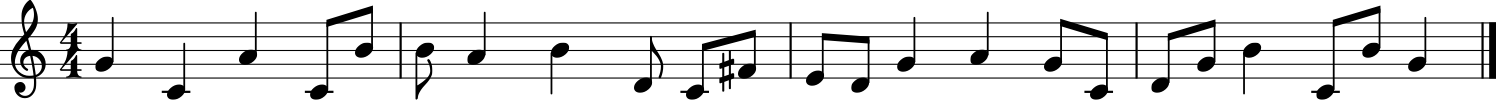

In [19]:
def play_midi(file_path):
    mf = midi.MidiFile()
    mf.open(file_path)
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    sp = midi.realtime.StreamPlayer(s)
    sp.play()
    
def main():
    setup_environment()

    initial_population = MusicPeace(4)  # amount of bars in melody G dur scale

    # AlgorithmConfig
    # evaluate_one_step = True
    # evaluate_two_steps = True
    # evaluate_three_steps = True
    # evaluate_same_distance = True
    # notes_relationship_config = NotesRelationshipConfig(True, True, True, True)

    
    # NotesRelationshipConfig
    # evaluate_degree = True
    # evaluate_drastic_duration_change = True
    # evaluate_note_melody_direction = True
    # evaluate_first_or_last_note = True

    config = AlgorithmConfig(True, True, True, True, NotesRelationshipConfig(True, True, True, True))

    final_population = genetic_algorithm(500, initial_population.all_notes, config)

    try:
        s1 = stream.Stream()
        for n in final_population:
            s1.append(n.music_note)
        s1.show()
        s1.show('midi')
    except Exception as e:
        print("Unexpected error:", str(e))

if __name__ == '__main__':
    main()
